# Face Recognition

## 1. Install packages

In [161]:
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray
from os import listdir
from mtcnn.mtcnn import MTCNN
from keras_facenet import inception_resnet_v1
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=ResourceWarning)
from tensorflow import keras as k
k.backend.set_image_data_format('channels_last')

## 2. Load Pre-trained FaceNet Model

In [162]:
def load_facenet():
    model = inception_resnet_v1.InceptionResNetV1(
        input_shape=(160, 160, 3),
        classes=128,
    )
    model.load_weights('keras-facenet-h5/model.h5')
    return model

In [163]:
model = load_facenet()
print(model.inputs)
print(model.outputs)

[<KerasTensor shape=(None, 160, 160, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_4050>]
[<KerasTensor shape=(None, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_4499>]


## 3. Face Detection and Extraction

In [164]:
def extract_image(image_path, detector: MTCNN):
    img = Image.open(image_path)
    img = img.convert('RGB')
    pixels = asarray(img)
    face = detector.detect_faces(pixels)
    
    x1, y1, w, h = face[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2 = x1 + w
    y2 = y1 + h
    
    store_face = pixels[y1:y2, x1:x2]
    plt.figure()
    plt.imshow(store_face)
    plt.title(f'Extracted face from {image_path}')
    face_img = Image.fromarray(store_face, 'RGB')
    face_img = face_img.resize((160, 160))  # Resize for FaceNet
    return asarray(face_img)

## 4. Database Creation

In [165]:
def load_faces(directory, detector):
    faces = []
    for filename in listdir(directory):
        file_path = directory + filename
        face = extract_image(file_path, detector)
        faces.append(face)
    return faces

In [166]:
def load_dataset(directory, detector):    
    x, y = [], []
    for subdir in listdir(directory):
        path = directory + subdir + '/'
        faces = load_faces(path, detector)
        labels = [subdir for _ in range(len(faces))]
        print(f'There are {len(faces)} images of {subdir} from Agrabah')
        x.extend(faces)
        y.extend(labels)
    return asarray(x), asarray(y)

In [167]:
def extract_embedding(model, face_image):
    img = np.around(np.array(face_image) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

## 5. Build Database

Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "C:\Users\MC\AppData\Local\Programs\Python\Python313\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "C:\Users\MC\AppData\Local\Programs\Python\Python313\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "C:\Users\MC\AppData\Local\Programs\Python\Python313\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.


There are 4 images of Marwan Kenzari from Agrabah
There are 2 images of Mena Massoud from Agrabah
There are 2 images of Naomi Scott from Agrabah
There are 3 images of Will Smith from Agrabah


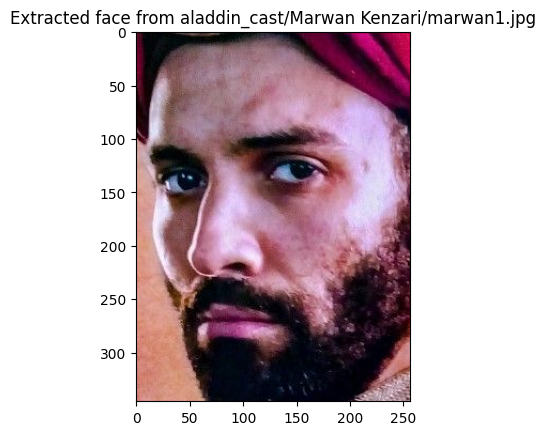

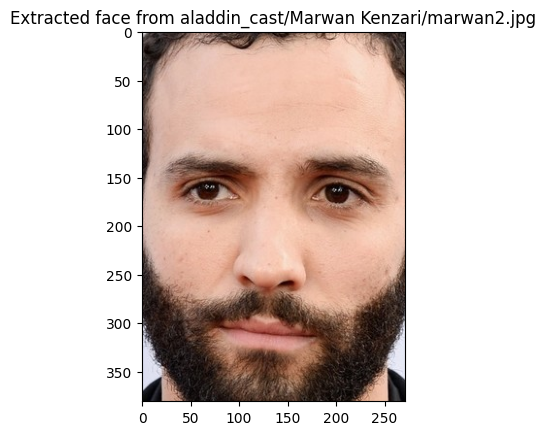

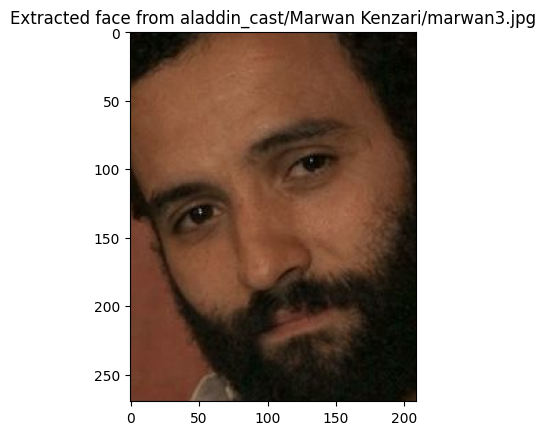

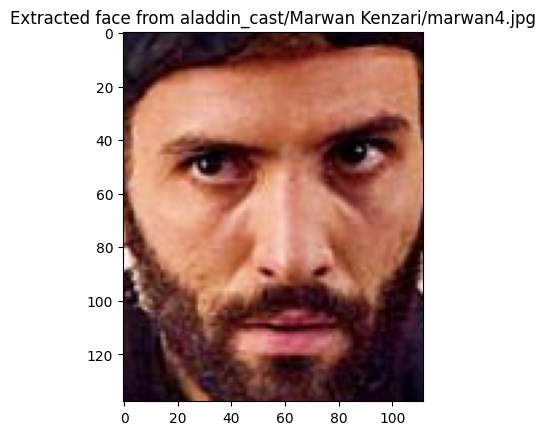

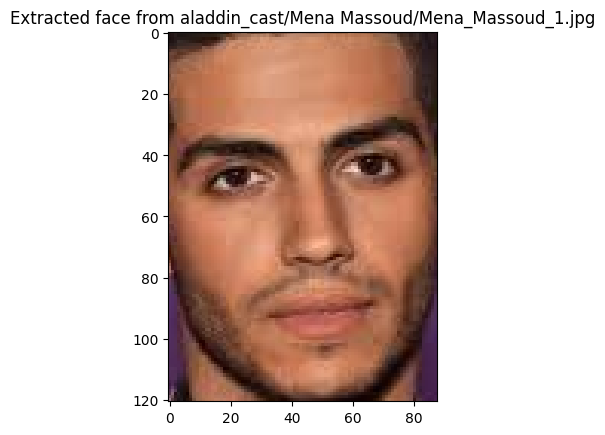

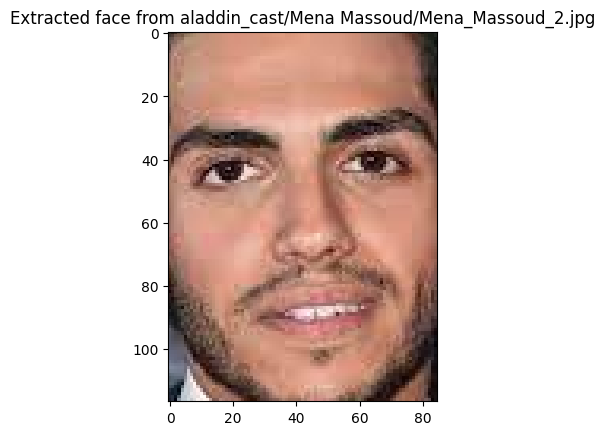

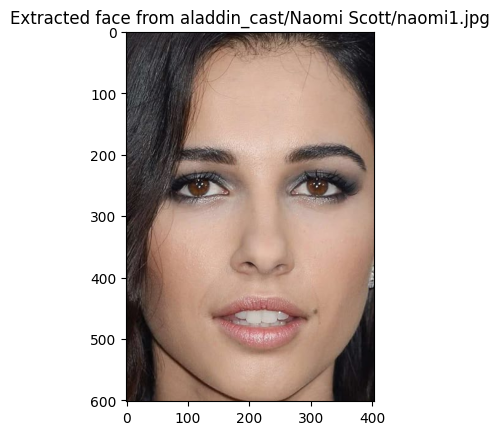

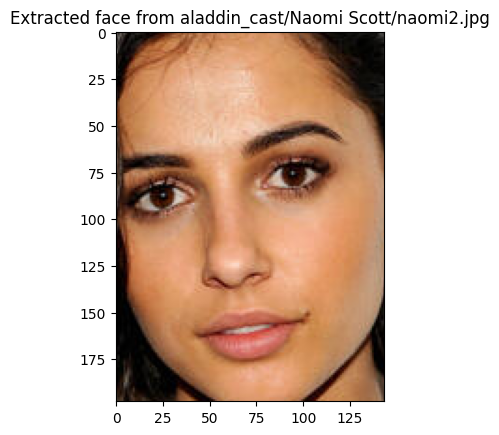

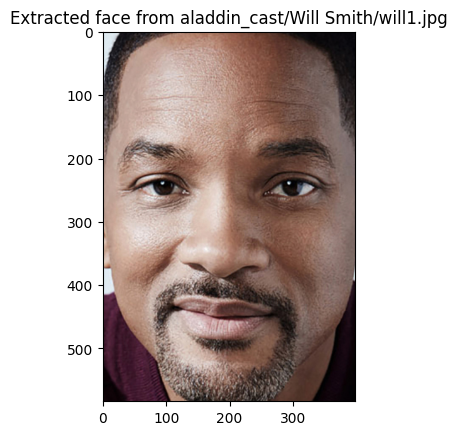

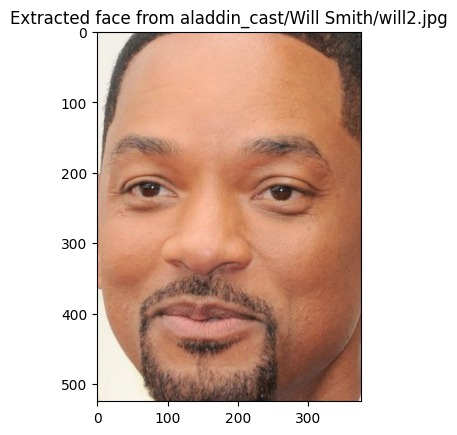

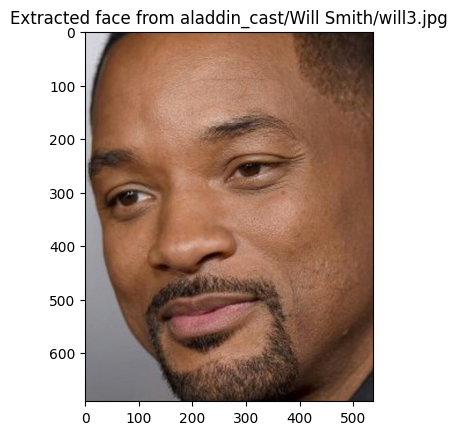

In [168]:
detector = MTCNN()
x, y = load_dataset('aladdin_cast/', detector)
database = {}
for idx, face in enumerate(x):
    database[y[idx]] = extract_embedding(model, face)

## 6. Face Recognition Function

In [169]:
def who_is_it(image_path, database, model, detector):
    # Define banned characters
    BANNED_CHARACTERS = ['jafar', 'marwan kenzari', 'vizier', 'evil vizier']
    
    # Character name mapping
    CHARACTER_MAP = {
        'mena massoud': 'Aladdin',
        'naomi scott': 'Jasmine', 
        'will smith': 'Genie',
        'marwan kenzari': 'Jafar'
    }
    
    try:
        face_image = extract_image(image_path, detector)
        new_encoding = extract_embedding(model, face_image)
    except Exception as e:
        print(f"ERROR: Could not process image")
        return None, None
    
    # Find closest match
    min_dist = 1000
    identity = "Unknown"
    
    for (name, encoding) in database.items():
        dist = np.linalg.norm(new_encoding - encoding, ord=2)
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    # Get display name
    display_name = CHARACTER_MAP.get(identity.lower(), identity)
    identity_lower = identity.lower()
    
    # Recognition decision
    if min_dist > 0.7:
        print(f"RESULT: Not in Aladdin database")
        return min_dist, identity
    
    if any(banned_name in identity_lower for banned_name in BANNED_CHARACTERS):
        print(f"RESULT: {display_name} - ACCESS DENIED")
    else:
        print(f"RESULT: {display_name} - ACCESS GRANTED")
    
    return min_dist, identity

In [170]:
## 8. System Tests

RESULT: Aladdin - ACCESS GRANTED


(np.float32(0.6377467), np.str_('Mena Massoud'))

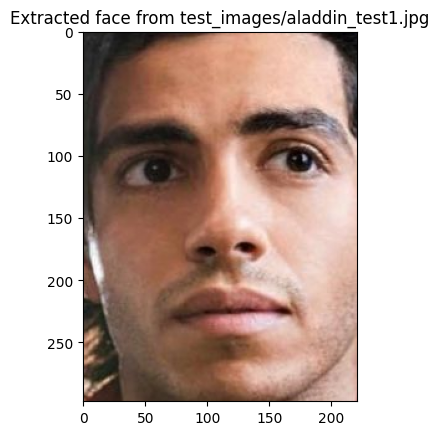

In [171]:
who_is_it('test_images/aladdin_test1.jpg', database, model, detector)

RESULT: Jasmine - ACCESS GRANTED


(np.float32(0.6851441), np.str_('Naomi Scott'))

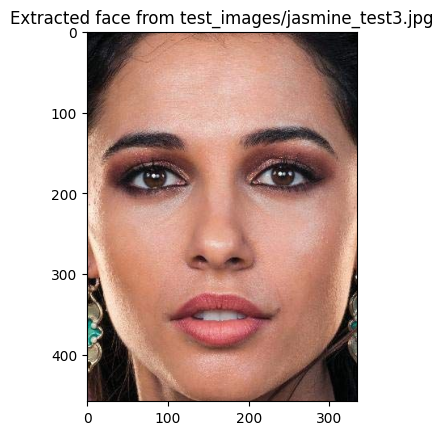

In [172]:
who_is_it('test_images/jasmine_test3.jpg', database, model, detector)

RESULT: Genie - ACCESS GRANTED


(np.float32(0.66899776), np.str_('Will Smith'))

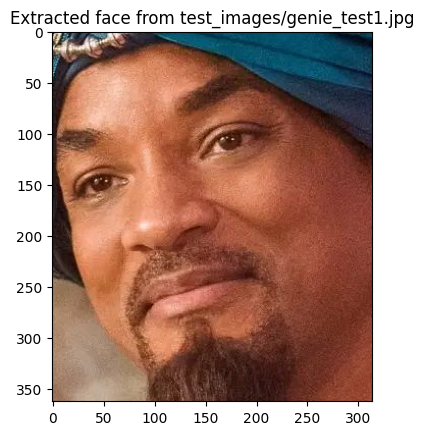

In [173]:
who_is_it('test_images/genie_test1.jpg', database, model, detector)

RESULT: Jafar - ACCESS DENIED


(np.float32(0.6631155), np.str_('Marwan Kenzari'))

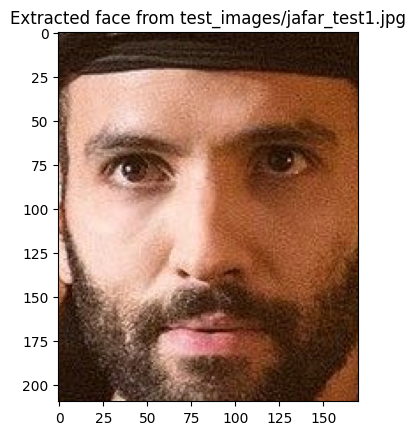

In [174]:
who_is_it('test_images/jafar_test1.jpg', database, model, detector)


Testing with characters outside Agrabah:
RESULT: Not in Aladdin database


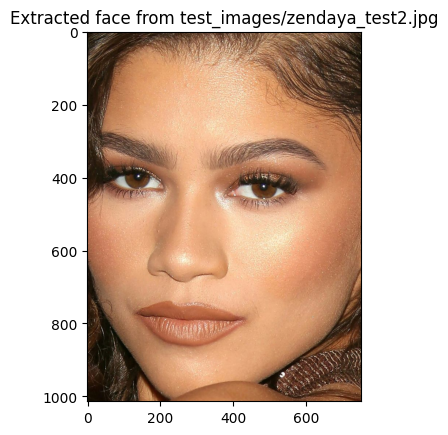

In [175]:
print("\nTesting with characters outside Agrabah:")
result = who_is_it('test_images/zendaya_test2.jpg', database, model, detector)